<a href="https://www.kaggle.com/code/aminojaghi1993/fast-ai-nb1-bird-detector?scriptVersionId=229211872" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Is it a bird?

In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
!pip install -Uq pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 56.7 MB/s eta 0:00:00


In [23]:
!pip install -Uq fastai fastbook

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

In [4]:
from time import sleep
import shutil

from fastcore.all import *
from fastbook import search_images_ddg as search_images
from fastdownload import download_url
from fastai.vision.all import (Image,  download_images, resize_images, Resize,
                               verify_images, get_image_files, vision_learner,
                               error_rate)
from fastai.vision.data import (DataBlock, ImageBlock, CategoryBlock,
                                RandomSplitter, parent_label)

from fastai.vision.all import resnet18
# for more model architectures see https://timm.fast.ai/

## Step 1: Download images of birds and non-birds

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

1
http://3.bp.blogspot.com/-i0B5H0Kcbv4/U86hbmU5vII/AAAAAAAAC_4/PH-eW0O1i94/s1600/lorikeets.jpg


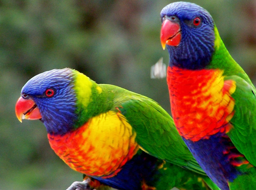

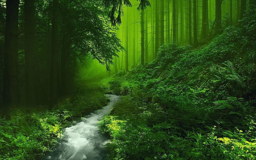

In [5]:
# `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#  If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bird photos', max_images=1)
print(len(urls))
print(urls[0])

dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)
display(Image.open(dest).to_thumb(256,256))

download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
display(Image.open('forest.jpg').to_thumb(256,256))

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [6]:
searches = 'forest','bird'
path = Path('bird_or_not')
if not path.exists():
  path.mkdir()

shutil.rmtree(path)

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo with jpg format', max_images=30))
    # we add jpg format term because this code can't handle other formats such as FPX
    sleep(4)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo with jpg format', max_images=30))
    sleep(4)
    download_images(dest, urls=search_images(f'{o} shade photo with jpg format', max_images=30))
    sleep(4)
    resize_images(path/o, max_size=400, dest=path/o)
    # this is because we don't necessarily need big images for most tasks, and we need fast iterations

In [7]:
!find ./bird_or_not/bird -type f -iname "*.*" | wc -l
# !find ./bird_or_not/forest -type f -iname "*.*" | wc -l

86


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

12

In [9]:
# !find ./bird_or_not/bird -type f -iname "*.*" | wc -l
!find ./bird_or_not/forest -type f -iname "*.*" | wc -l

77


To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

In [10]:
# ?DataBlock
# ??DataBlock
# ??L

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
    # we need fast iterations
    # besides, almost all models require images to be the same size
).dataloaders(path, bs=32)

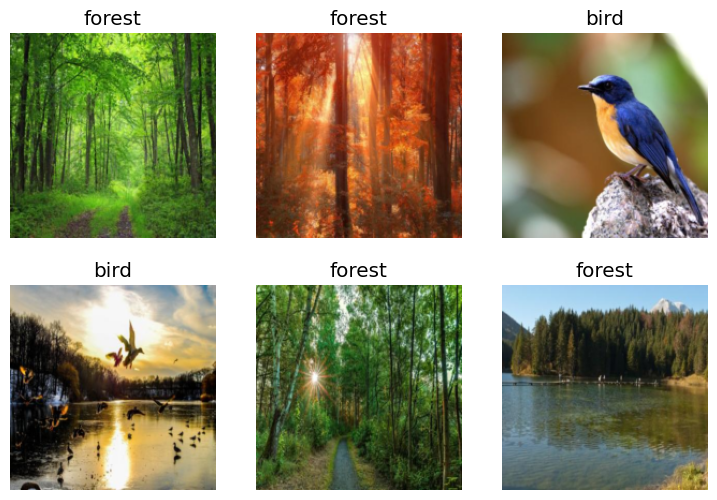

In [12]:
dls.show_batch(max_n=6)

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
# `fastai` comes with a helpful `fine_tune()` method which automatically uses
# best practices for fine tuning a pre-trained model, so we'll use that.
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.530531,2.303157,0.451613,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.448065,0.682225,0.193548,00:00
1,0.328119,0.150560,0.096774,00:01
2,0.237702,0.036614,0.000000,00:01


"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories)

## Step 3: Use our model

Let's see what our model thinks about that bird we downloaded at the start:

In [14]:
from fastai.vision.all import PILImage
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9957


## Step 4: Saving a model

In [15]:
from fastai.vision.all import URLs, untar_data, ImageDataLoaders

In [16]:
print(URLs.PETS)
path = untar_data(URLs.PETS)/'images'
print(path)

https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz


/root/.fastai/data/oxford-iiit-pet/images


In [17]:
def is_cat(x):
  # print(x) # to check what is fed to the function
  return x[0].isupper()

In [18]:
# ??ImageDataLoaders.from_name_func

In [19]:
# get_image_files(path)

In [20]:
dls = ImageDataLoaders.from_name_func('.',
    get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat,
    item_tfms=Resize(192))

In [21]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.181210,0.055664,0.020974,00:38


epoch,train_loss,valid_loss,error_rate,time
0,0.088227,0.048623,0.016238,00:41
1,0.035527,0.017418,0.006766,00:39
2,0.022414,0.017064,0.006089,00:39


In [22]:
learn.export('model.pkl')

In [24]:
# we can deploy the model using HuggingFace repo + Graidio/Strealit